A comparison between LR and NWAY methods
======================================

We crossmatch XXL-North X-ray sources with SDSS optical sources, both selected within a 1 deg radius circle, using the LR and NWAY methods, and compare the results.

Definition of the catalogues and set crossmatch:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from mocpy import MOC

from astromatch import Catalogue, Match


# Common MOC
region_center = SkyCoord(ra=35.30109, dec=-4.45962, unit='deg')
search_radius = 1*u.deg

moc_xxl = MOC.from_elliptical_cone(
    lon=region_center.ra,
    lat=region_center.dec,
    a=search_radius,
    b=search_radius,
    pa=0*u.deg,
    max_depth=14
)

# X-rays
xcat = Catalogue(
    'xxl_1deg.fits',
    name='xxl',
    id_col='Xseq',
    coord_cols=['RABdeg', 'DEBdeg'],
    poserr_cols=['e_Bpos'],
    poserr_type='circle',
    area=moc_xxl,
)
xcat.poserr.components = Table([xcat.poserr.components['e_Bpos'] / np.sqrt(2)])

# Optical
ocat = Catalogue(
    'sdss_1deg.fits',
    name='sdss',
    id_col='objID',
    coord_cols=['RA_ICRS', 'DE_ICRS'],
    poserr_cols=['e_RA_ICRS', 'e_DE_ICRS'],
    poserr_type='rcd_dec_ellipse',
    area=moc_xxl,
    mag_cols=['umag', 'gmag', 'rmag', 'imag', 'zmag'],
)

xm = Match(xcat, ocat)

INFO: Selecting sources in common area... [astromatch.core]
INFO: xxl catalogue: 1238 sources in common area. [astromatch.core]
INFO: sdss catalogue: 43559 sources in common area. [astromatch.core]


Cross-matching using LR method:

In [13]:
results_lr = xm.run(method='lr', radius=10.0*u.arcsec, poserr_dist="normal")
matchs_lr_primary = xm.get_matchs(match_type='primary')

INFO: Using LR method: [astromatch.core]
INFO: Searching for match candidates within 10.0 arcsec... [astromatch.lr]
INFO: Calculating priors... [astromatch.lr]
INFO: Estimating priors using Catalogues: xxl and sdss... [astromatch.priors]
INFO: Using columns: ['umag', 'gmag', 'rmag', 'imag', 'zmag'] [astromatch.priors]
INFO: Calculating likelihood ratios for match candidates... [astromatch.lr]
INFO: Sorting and flagging match results... [astromatch.lr]


Save calculated magnitude priors for later use:

In [4]:
prior_table = xm.priors.to_table(include_bkg_priors=True)
prior_table.write("lrpriors.fits", format="fits", overwrite=True)

Cross-matching using NWAY (default magnitude priors):

In [5]:
results_nway_dfprior = xm.run(method='nway', radius=10.0*u.arcsec, use_mags=True, prior_completeness=0.55)
matchs_nway_dfprior_primary = xm.get_matchs(match_type='primary')

    adding angular separation columns
matching:   2311 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (43559), density gives 5.69e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
  0%|          | 0/1238 [00:00<?, ?it/s]

INFO: Using NWAY method: [astromatch.core]


100%|██████████| 1238/1238 [00:01<00:00, 1027.76it/s]
Incorporating bias "sdss:umag" ...
magnitude histogram of column "sdss_umag": 439 secure matches, 683 insecure matches and 42876 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_umag_fit.txt".
Incorporating bias "sdss:gmag" ...
magnitude histogram of column "sdss_gmag": 439 secure matches, 683 insecure matches and 42876 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_gmag_fit.txt".
Incorporating bias "sdss:rmag" ...
magnitude histogram of column "sdss_rmag": 439 secure matches, 683 insecure matches and 42876 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_rmag_fit.txt".
Incorporating bias "sdss:imag" ...
magnitude histogram of column "sdss_imag": 439 secure matches, 683 insecure matches and 42876 secure non-matches of 43559 total entries (43559 valid)
magnitude histogram stored to "sdss_imag_fit.txt".
In

INFO: Using provided prior... [astromatch.priors]


Cross-matching using NWAY (LR magnitude priors):

In [6]:
from astromatch.priors import Prior

prior_labels = [f"PRIOR{i}" for i in range(5)]
priors = {'sdss': Prior.from_table("lrpriors.fits", prior_labels)}

results_nway_lrprior = xm.run(
    method='nway', radius=10.0*u.arcsec, prior_completeness=0.55, use_mags=True, priors=priors
)
matchs_nway_lrprior_primary = xm.get_matchs(match_type='primary')

    adding angular separation columns
matching:   2311 matches after filtering by search radius
Primary catalogue "xxl" (1238), density gives 1.62e+07 objects on entire sky
Catalogue "sdss" (43559), density gives 5.69e+08 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
 17%|█▋        | 215/1238 [00:00<00:00, 1061.40it/s]

INFO: Using provided prior... [astromatch.priors]
INFO: Using NWAY method: [astromatch.core]


100%|██████████| 1238/1238 [00:01<00:00, 1062.10it/s]
Incorporating bias "sdss:umag" ...
magnitude histogramming: using user-supplied histogram for "sdss_umag"
Incorporating bias "sdss:gmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_gmag"
Incorporating bias "sdss:rmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_rmag"
Incorporating bias "sdss:imag" ...
magnitude histogramming: using user-supplied histogram for "sdss_imag"
Incorporating bias "sdss:zmag" ...
magnitude histogramming: using user-supplied histogram for "sdss_zmag"

Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...


Comparison of results
-------------------------------

Identification rate:

In [7]:
lr_id_rate = 100 * len(matchs_lr_primary) / len(xcat)
print(f"LR identification rate :{lr_id_rate:.1f}%")

lr_nway_dfprior_rate = 100 * len(matchs_nway_dfprior_primary) / len(xcat)
print(f"NWAY (default prior) identification rate :{lr_nway_dfprior_rate:.1f}%")

lr_nway_lrprior_rate = 100 * len(matchs_nway_lrprior_primary) / len(xcat)
print(f"NWAY (LR prior) identification rate :{lr_nway_lrprior_rate:.1f}%")

LR identification rate :68.2%
NWAY (default prior) identification rate :68.2%
NWAY (LR prior) identification rate :68.2%


prob_has_match distributions:

In [ ]:
plt.hist(
    matchs_lr_primary["prob_has_match"], label="LR", bins=20,
)

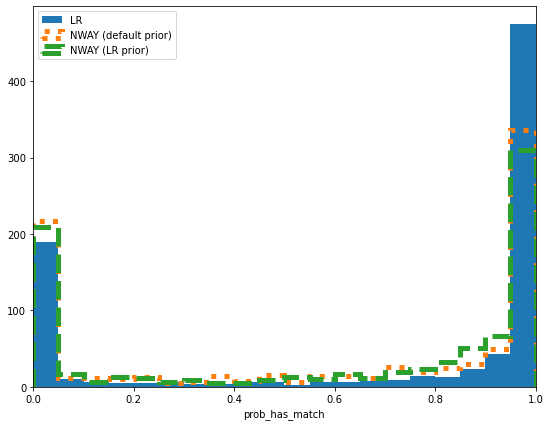

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))

_, bins, _ = plt.hist(
    matchs_lr_primary["prob_has_match"], label="LR", range=(0,1), bins=20,
)
plt.hist(
    matchs_nway_dfprior_primary["prob_has_match"],
    label="NWAY (default prior)",
    histtype='step',
    lw=5,
    ls=":",
    bins=bins
)
plt.hist(
    matchs_nway_lrprior_primary["prob_has_match"],
    label="NWAY (LR prior)",
    histtype='step',
    lw=5,
    ls="--",
    bins=bins
)

plt.legend()

plt.xlim(0, 1)
plt.xlabel("prob_has_match")

plt.show()

In [ ]:
import numpy as np
from astropy.table import join

matchs_lr_primary_ids = matchs_lr_primary[["SRCID_xxl", "SRCID_sdss"]]
matchs_nway_dfprior_primary_ids = matchs_nway_dfprior_primary[["SRCID_xxl", "SRCID_sdss"]]
matchs_nway_lrprior_primary_ids = matchs_nway_lrprior_primary[["SRCID_xxl", "SRCID_sdss"]]

lr_nway_dfprior = join(
    matchs_lr_primary_ids,
    matchs_nway_dfprior_primary_ids,
    join_type="left",
    keys=["SRCID_xxl"],
    table_names=["lr", "nway"],
)

equal_ids = len(np.where(lr_nway_dfprior["SRCID_sdss_lr"] == lr_nway_dfprior["SRCID_sdss_nway"])[0])
percent_equal_ids = 100 * equal_ids / len(lr_nway_dfprior)

print(f"LR and NWAY (default prior) get the same counterpart for {percent_equal_ids:.1f}% of the X-ray sources.")


lr_nway_lrprior = join(matchs_lr_primary_ids, matchs_nway_lrprior_primary_ids,
                       join_type="left", keys=["SRCID_xxl"], table_names=["lr", "nway"])

equal_ids = len(np.where(lr_nway_lrprior["SRCID_sdss_lr"] == lr_nway_lrprior["SRCID_sdss_nway"])[0])
percent_equal_ids = 100 * equal_ids / len(lr_nway_lrprior)

print(f"LR and NWAY (LR prior) get the same counterpart for {percent_equal_ids:.1f}% of the X-ray sources.")

In [ ]:
#import numpy as np

x = np.linspace(0, 10, num=500)
sigma2 = 3
y = np.abs(x) * np.exp(-x**2/(2*sigma2))


plt.plot(x,y)
plt.show()